# FMLIKH Model: Small Amplitude Oscillatory Shear (SAOS)

## Protocol-Specific Context (Multi-Mode)

**FMLIKH SAOS** produces **broadened relaxation spectra** spanning decades of frequency:

1. **Multiple crossover frequencies**: $\omega_c,i \sim 1/\tau_i$ for each mode
2. **Composite Cole-Cole**: Superposition of depressed arcs with angle(s) $\theta_i = (1-\alpha_i)\pi/2$
3. **Extended power-law regimes**: $G' \sim \omega^{\alpha}$ over wider frequency range

**Why this matters**: Single-mode FIKH has limited frequency range. FMLIKH with N=3 can capture **broad experimental spectra** from 0.001 Hz to 100 Hz — fast modes respond at high frequency, slow modes at low frequency.

> **Physical insight**: Each structural level contributes to viscoelasticity at its characteristic frequency $\omega \sim 1/\tau_i$. Fast aggregates respond quickly (high $\omega$), slow networks respond slowly (low $\omega$). Fractional kinetics broadens each mode's contribution.

> **Handbook:** See [FMLIKH SAOS](../../docs/source/models/fikh/fmlikh.rst) for multi-mode Cole-Cole analysis.

## Learning Objectives

1. Compute FMLIKH SAOS moduli with N=3 modes
2. Observe broadened frequency response (vs single-mode)
3. Analyze mode contributions to $G'$, $G''$ at different frequencies
4. Plot composite Cole-Cole and identify mode features
5. Extract relaxation spectrum from SAOS data

## Prerequisites

- NB07: FMLIKH flow curve
- NB05: FIKH SAOS (single-mode baseline)

**Estimated Time:** 4-6 minutes (fast), 15-20 minutes (full)

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import os
import sys
import time
import warnings

# Robust path resolution for execution from any directory
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    generate_synthetic_saos,
    get_fmlikh_param_names,
    load_fikh_parameters,
    print_convergence_summary,
    save_fikh_results,
    set_model_parameters,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# ============================================================
# FAST_MODE Configuration
# ============================================================
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    print("FAST_MODE: reduced data/samples for quick validation")
    N_TIME_POINTS = 50  # Reduced from 200
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    print("FULL mode: complete Bayesian inference")
    N_TIME_POINTS = 200  # Full resolution
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

FAST_MODE: reduced data/samples for quick validation


## 2. Load Calibrated Parameters

In [3]:
N_MODES = 3
model = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.7)

try:
    params = load_fikh_parameters("fmlikh", "flow_curve")
    set_model_parameters(model, params)
    print("Loaded parameters from NB07")
except FileNotFoundError:
    print("Using default parameters")

Loaded parameters from NB07


## 3. Generate Synthetic Data

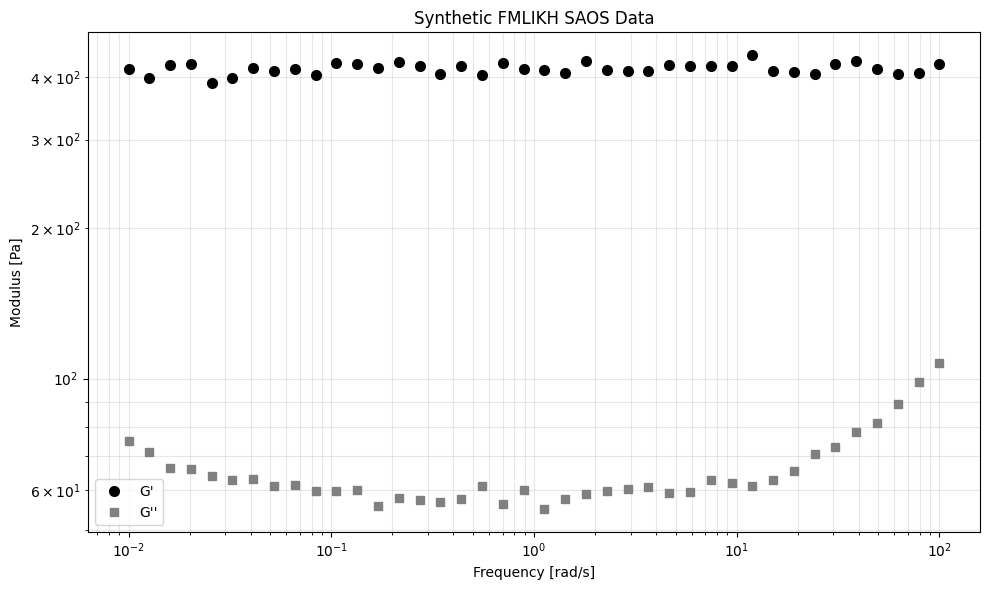

In [4]:
OMEGA_RANGE = (0.01, 100.0)
omega_data, G_prime_data, G_double_prime_data = generate_synthetic_saos(
    model, omega_range=OMEGA_RANGE, n_points=40, noise_level=0.03, seed=42
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(omega_data, G_prime_data, "ko", markersize=7, label="G'")
ax.loglog(omega_data, G_double_prime_data, "s", color="gray", markersize=6, label="G''")
ax.set_xlabel("Frequency [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("Synthetic FMLIKH SAOS Data")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Mode Contribution Analysis

In [5]:
# Each mode has characteristic frequency 1/tau_i
mode_info = model.get_mode_info()
omega_fine = np.logspace(np.log10(OMEGA_RANGE[0]), np.log10(OMEGA_RANGE[1]), 100)

print("Mode characteristic frequencies:")
for m in mode_info["modes"]:
    omega_c = 1.0 / m["tau"] if m["tau"] > 0 else float("inf")
    print(f"  Mode {m['mode']}: ω_c = {omega_c:.4g} rad/s (τ = {m['tau']:.4g} s)")

Mode characteristic frequencies:
  Mode 0: ω_c = 0.001 rad/s (τ = 1000 s)
  Mode 1: ω_c = 0.001 rad/s (τ = 1000 s)
  Mode 2: ω_c = 0.001 rad/s (τ = 1000 s)


## 5. Bayesian Inference

In [6]:
model_fit = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.5)
G_star_data = G_prime_data + 1j * G_double_prime_data

# For SAOS, create synthetic time-domain oscillation data
# Use low frequency for fitting
omega_fit = np.median(omega_data)
period = 2 * np.pi / omega_fit
t_fit = np.linspace(0, 5 * period, N_TIME_POINTS)
gamma_0 = 0.01
strain_fit = gamma_0 * np.sin(omega_fit * t_fit)

# Use G_prime as proxy for stress magnitude (simplified)
stress_fit = G_prime_data[len(G_prime_data)//2] * strain_fit

model_fit.fit(t_fit, stress_fit, test_mode="startup", strain=strain_fit, method='scipy')

param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)
initial_values = {n: model_fit.parameters.get_value(n) for n in param_names if n in model_fit.parameters}

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
print(f"  FAST_MODE={FAST_MODE}, time points={len(t_fit)}")

t0 = time.time()
result = model_fit.fit_bayesian(
    t_fit, stress_fit, test_mode="startup", strain=strain_fit,
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
print(f"Bayesian time: {time.time() - t0:.1f} s")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fmlikh.py", line 561, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


Running NUTS: 50 warmup + 100 samples x 1 chain(s)
  FAST_MODE=True, time points=50


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:02<06:25,  2.59s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   4%|▍         | 6/150 [00:02<00:49,  2.88it/s, 102 steps of size 2.46e-03. acc. prob=0.45]

warmup:   5%|▌         | 8/150 [00:02<00:36,  3.84it/s, 55 steps of size 5.98e-04. acc. prob=0.51] 

warmup:   7%|▋         | 10/150 [00:03<00:32,  4.35it/s, 255 steps of size 1.00e-03. acc. prob=0.61]

warmup:   8%|▊         | 12/150 [00:03<00:28,  4.92it/s, 222 steps of size 1.06e-03. acc. prob=0.66]

warmup:   9%|▊         | 13/150 [00:03<00:26,  5.25it/s, 205 steps of size 6.80e-04. acc. prob=0.66]

warmup:   9%|▉         | 14/150 [00:03<00:25,  5.38it/s, 255 steps of size 9.24e-04. acc. prob=0.69]

warmup:  10%|█         | 15/150 [00:03<00:23,  5.82it/s, 191 steps of size 4.83e-04. acc. prob=0.69]

warmup:  11%|█         | 16/150 [00:04<00:22,  5.86it/s, 255 steps of size 3.66e-04. acc. prob=0.69]

warmup:  11%|█▏        | 17/150 [00:04<00:22,  5.91it/s, 255 steps of size 3.40e-04. acc. prob=0.70]

warmup:  12%|█▏        | 18/150 [00:04<00:22,  5.93it/s, 255 steps of size 4.30e-04. acc. prob=0.72]

warmup:  13%|█▎        | 19/150 [00:04<00:22,  5.95it/s, 255 steps of size 5.99e-04. acc. prob=0.73]

warmup:  13%|█▎        | 20/150 [00:04<00:20,  6.20it/s, 205 steps of size 5.36e-04. acc. prob=0.74]

warmup:  14%|█▍        | 21/150 [00:04<00:19,  6.63it/s, 166 steps of size 3.14e-04. acc. prob=0.73]

warmup:  15%|█▍        | 22/150 [00:05<00:19,  6.45it/s, 255 steps of size 4.59e-04. acc. prob=0.75]

warmup:  15%|█▌        | 23/150 [00:05<00:20,  6.33it/s, 255 steps of size 2.13e-04. acc. prob=0.74]

warmup:  16%|█▌        | 24/150 [00:05<00:20,  6.23it/s, 255 steps of size 2.99e-04. acc. prob=0.75]

warmup:  17%|█▋        | 25/150 [00:05<00:20,  6.15it/s, 255 steps of size 4.02e-04. acc. prob=0.76]

warmup:  17%|█▋        | 26/150 [00:05<00:20,  6.10it/s, 255 steps of size 3.21e-04. acc. prob=0.76]

warmup:  18%|█▊        | 27/150 [00:05<00:20,  6.07it/s, 255 steps of size 3.27e-04. acc. prob=0.76]

warmup:  19%|█▊        | 28/150 [00:06<00:20,  6.05it/s, 255 steps of size 4.27e-04. acc. prob=0.77]

warmup:  20%|██        | 30/150 [00:06<00:17,  6.75it/s, 255 steps of size 2.23e-04. acc. prob=0.77]

warmup:  21%|██        | 31/150 [00:06<00:18,  6.54it/s, 255 steps of size 2.95e-04. acc. prob=0.78]

warmup:  21%|██▏       | 32/150 [00:06<00:18,  6.40it/s, 255 steps of size 2.32e-04. acc. prob=0.78]

warmup:  22%|██▏       | 33/150 [00:06<00:18,  6.28it/s, 255 steps of size 2.84e-04. acc. prob=0.78]

warmup:  23%|██▎       | 34/150 [00:07<00:18,  6.20it/s, 255 steps of size 3.96e-04. acc. prob=0.79]

warmup:  24%|██▍       | 36/150 [00:07<00:16,  7.05it/s, 255 steps of size 1.63e-04. acc. prob=0.78]

warmup:  25%|██▍       | 37/150 [00:07<00:16,  6.74it/s, 255 steps of size 2.24e-04. acc. prob=0.79]

warmup:  25%|██▌       | 38/150 [00:07<00:17,  6.54it/s, 255 steps of size 2.20e-04. acc. prob=0.79]

warmup:  26%|██▌       | 39/150 [00:07<00:17,  6.39it/s, 255 steps of size 2.73e-04. acc. prob=0.79]

warmup:  27%|██▋       | 40/150 [00:07<00:17,  6.26it/s, 255 steps of size 2.82e-04. acc. prob=0.80]

warmup:  27%|██▋       | 41/150 [00:08<00:17,  6.19it/s, 255 steps of size 3.89e-04. acc. prob=0.80]

warmup:  29%|██▊       | 43/150 [00:08<00:14,  7.22it/s, 255 steps of size 2.79e-04. acc. prob=0.80]

warmup:  29%|██▉       | 44/150 [00:08<00:15,  6.87it/s, 255 steps of size 3.83e-04. acc. prob=0.81]

warmup:  31%|███       | 46/150 [00:08<00:14,  7.38it/s, 255 steps of size 1.20e-03. acc. prob=0.80]

warmup:  31%|███▏      | 47/150 [00:08<00:14,  7.01it/s, 255 steps of size 1.60e-03. acc. prob=0.80]

warmup:  32%|███▏      | 48/150 [00:09<00:15,  6.74it/s, 255 steps of size 2.22e-03. acc. prob=0.81]

warmup:  33%|███▎      | 49/150 [00:09<00:15,  6.50it/s, 255 steps of size 3.12e-03. acc. prob=0.81]

warmup:  33%|███▎      | 50/150 [00:09<00:15,  6.36it/s, 255 steps of size 2.50e-03. acc. prob=0.81]

sample:  34%|███▍      | 51/150 [00:09<00:15,  6.24it/s, 255 steps of size 2.50e-03. acc. prob=0.99]

sample:  35%|███▍      | 52/150 [00:09<00:15,  6.19it/s, 255 steps of size 2.50e-03. acc. prob=0.98]

sample:  35%|███▌      | 53/150 [00:09<00:15,  6.15it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  36%|███▌      | 54/150 [00:10<00:15,  6.12it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  37%|███▋      | 55/150 [00:10<00:15,  6.10it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  37%|███▋      | 56/150 [00:10<00:15,  6.08it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  38%|███▊      | 57/150 [00:10<00:15,  6.05it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  39%|███▊      | 58/150 [00:10<00:15,  6.05it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  39%|███▉      | 59/150 [00:10<00:15,  6.02it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  40%|████      | 60/150 [00:11<00:14,  6.03it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  41%|████      | 61/150 [00:11<00:14,  6.02it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  41%|████▏     | 62/150 [00:11<00:14,  6.02it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  42%|████▏     | 63/150 [00:11<00:14,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  43%|████▎     | 64/150 [00:11<00:14,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  43%|████▎     | 65/150 [00:11<00:14,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  44%|████▍     | 66/150 [00:12<00:13,  6.02it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  45%|████▍     | 67/150 [00:12<00:13,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.98]

sample:  45%|████▌     | 68/150 [00:12<00:13,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  46%|████▌     | 69/150 [00:12<00:13,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.98]

sample:  47%|████▋     | 70/150 [00:12<00:13,  6.02it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  47%|████▋     | 71/150 [00:12<00:13,  5.99it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  48%|████▊     | 72/150 [00:13<00:12,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  49%|████▊     | 73/150 [00:13<00:12,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  49%|████▉     | 74/150 [00:13<00:12,  6.02it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  50%|█████     | 75/150 [00:13<00:12,  5.99it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  51%|█████     | 76/150 [00:13<00:12,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  51%|█████▏    | 77/150 [00:13<00:12,  6.02it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  52%|█████▏    | 78/150 [00:14<00:11,  6.02it/s, 255 steps of size 2.50e-03. acc. prob=0.97]

sample:  53%|█████▎    | 79/150 [00:14<00:11,  6.03it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  53%|█████▎    | 80/150 [00:14<00:11,  6.03it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  54%|█████▍    | 81/150 [00:14<00:11,  6.02it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  55%|█████▍    | 82/150 [00:14<00:11,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  55%|█████▌    | 83/150 [00:14<00:11,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  56%|█████▌    | 84/150 [00:15<00:10,  6.03it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  57%|█████▋    | 85/150 [00:15<00:10,  6.04it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  57%|█████▋    | 86/150 [00:15<00:10,  6.04it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  58%|█████▊    | 87/150 [00:15<00:10,  5.99it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  59%|█████▊    | 88/150 [00:15<00:10,  5.98it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  59%|█████▉    | 89/150 [00:15<00:10,  5.98it/s, 255 steps of size 2.50e-03. acc. prob=0.95]

sample:  60%|██████    | 90/150 [00:16<00:10,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.95]

sample:  61%|██████    | 91/150 [00:16<00:09,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  61%|██████▏   | 92/150 [00:16<00:09,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.96]

sample:  62%|██████▏   | 93/150 [00:16<00:09,  5.93it/s, 255 steps of size 2.50e-03. acc. prob=0.95]

sample:  63%|██████▎   | 94/150 [00:16<00:09,  5.96it/s, 255 steps of size 2.50e-03. acc. prob=0.95]

sample:  63%|██████▎   | 95/150 [00:16<00:09,  5.98it/s, 255 steps of size 2.50e-03. acc. prob=0.95]

sample:  64%|██████▍   | 96/150 [00:17<00:09,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  65%|██████▍   | 97/150 [00:17<00:08,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  65%|██████▌   | 98/150 [00:17<00:08,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  66%|██████▌   | 99/150 [00:17<00:08,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  67%|██████▋   | 100/150 [00:17<00:08,  5.69it/s, 255 steps of size 2.50e-03. acc. prob=0.95]

sample:  67%|██████▋   | 101/150 [00:17<00:08,  5.80it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  68%|██████▊   | 102/150 [00:18<00:08,  5.87it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  69%|██████▊   | 103/150 [00:18<00:07,  5.91it/s, 255 steps of size 2.50e-03. acc. prob=0.95]

sample:  69%|██████▉   | 104/150 [00:18<00:07,  5.94it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  70%|███████   | 105/150 [00:18<00:07,  5.94it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  71%|███████   | 106/150 [00:18<00:07,  5.94it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  71%|███████▏  | 107/150 [00:18<00:07,  5.96it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  72%|███████▏  | 108/150 [00:19<00:07,  5.96it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  73%|███████▎  | 109/150 [00:19<00:06,  5.97it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  73%|███████▎  | 110/150 [00:19<00:06,  5.97it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  74%|███████▍  | 111/150 [00:19<00:06,  5.98it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  75%|███████▍  | 112/150 [00:19<00:06,  5.98it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  75%|███████▌  | 113/150 [00:19<00:06,  5.99it/s, 255 steps of size 2.50e-03. acc. prob=0.94]

sample:  76%|███████▌  | 114/150 [00:20<00:05,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.93]

sample:  77%|███████▋  | 115/150 [00:20<00:05,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.93]

sample:  77%|███████▋  | 116/150 [00:20<00:05,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.93]

sample:  78%|███████▊  | 117/150 [00:20<00:05,  5.99it/s, 255 steps of size 2.50e-03. acc. prob=0.92]

sample:  79%|███████▊  | 118/150 [00:20<00:05,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.92]

sample:  79%|███████▉  | 119/150 [00:20<00:05,  5.99it/s, 255 steps of size 2.50e-03. acc. prob=0.93]

sample:  80%|████████  | 120/150 [00:21<00:04,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.93]

sample:  81%|████████  | 121/150 [00:21<00:04,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.92]

sample:  81%|████████▏ | 122/150 [00:21<00:04,  5.99it/s, 255 steps of size 2.50e-03. acc. prob=0.92]

sample:  82%|████████▏ | 123/150 [00:21<00:04,  5.98it/s, 255 steps of size 2.50e-03. acc. prob=0.92]

sample:  83%|████████▎ | 124/150 [00:21<00:04,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.92]

sample:  83%|████████▎ | 125/150 [00:21<00:04,  6.01it/s, 255 steps of size 2.50e-03. acc. prob=0.92]

sample:  84%|████████▍ | 126/150 [00:22<00:03,  6.00it/s, 255 steps of size 2.50e-03. acc. prob=0.92]

sample:  85%|████████▌ | 128/150 [00:22<00:03,  6.88it/s, 255 steps of size 2.50e-03. acc. prob=0.91]

sample:  86%|████████▌ | 129/150 [00:22<00:03,  6.63it/s, 255 steps of size 2.50e-03. acc. prob=0.91]

sample:  87%|████████▋ | 130/150 [00:22<00:03,  6.46it/s, 255 steps of size 2.50e-03. acc. prob=0.91]

sample:  87%|████████▋ | 131/150 [00:22<00:03,  6.33it/s, 255 steps of size 2.50e-03. acc. prob=0.91]

sample:  88%|████████▊ | 132/150 [00:22<00:02,  6.24it/s, 255 steps of size 2.50e-03. acc. prob=0.91]

sample:  89%|████████▊ | 133/150 [00:23<00:02,  6.19it/s, 255 steps of size 2.50e-03. acc. prob=0.91]

sample:  89%|████████▉ | 134/150 [00:23<00:02,  6.14it/s, 255 steps of size 2.50e-03. acc. prob=0.90]

sample:  90%|█████████ | 135/150 [00:23<00:02,  6.08it/s, 255 steps of size 2.50e-03. acc. prob=0.90]

sample:  91%|█████████ | 136/150 [00:23<00:02,  5.76it/s, 255 steps of size 2.50e-03. acc. prob=0.90]

sample:  91%|█████████▏| 137/150 [00:23<00:02,  5.84it/s, 255 steps of size 2.50e-03. acc. prob=0.90]

sample:  92%|█████████▏| 138/150 [00:23<00:02,  5.89it/s, 255 steps of size 2.50e-03. acc. prob=0.90]

sample:  93%|█████████▎| 139/150 [00:24<00:01,  5.94it/s, 255 steps of size 2.50e-03. acc. prob=0.89]

sample:  93%|█████████▎| 140/150 [00:24<00:01,  5.96it/s, 255 steps of size 2.50e-03. acc. prob=0.89]

sample:  94%|█████████▍| 141/150 [00:24<00:01,  5.97it/s, 255 steps of size 2.50e-03. acc. prob=0.88]

sample:  95%|█████████▌| 143/150 [00:24<00:00,  7.25it/s, 255 steps of size 2.50e-03. acc. prob=0.87]

sample:  96%|█████████▌| 144/150 [00:24<00:00,  6.90it/s, 255 steps of size 2.50e-03. acc. prob=0.86]

sample:  97%|█████████▋| 145/150 [00:25<00:00,  6.65it/s, 255 steps of size 2.50e-03. acc. prob=0.86]

sample:  97%|█████████▋| 146/150 [00:25<00:00,  6.47it/s, 255 steps of size 2.50e-03. acc. prob=0.86]

sample:  98%|█████████▊| 147/150 [00:25<00:00,  6.94it/s, 179 steps of size 2.50e-03. acc. prob=0.85]

sample:  99%|█████████▊| 148/150 [00:25<00:00,  6.62it/s, 255 steps of size 2.50e-03. acc. prob=0.85]

sample:  99%|█████████▉| 149/150 [00:25<00:00,  6.44it/s, 255 steps of size 2.50e-03. acc. prob=0.85]

sample: 100%|██████████| 150/150 [00:25<00:00,  6.32it/s, 255 steps of size 2.50e-03. acc. prob=0.85]

sample: 100%|██████████| 150/150 [00:25<00:00,  5.81it/s, 255 steps of size 2.50e-03. acc. prob=0.85]

Bayesian time: 29.3 s


Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    2.4449         3     CHECK
            G_1    2.4582         3     CHECK
alpha_structure    2.7548         3     CHECK

Divergences: 3

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start

### Diagnostic Targets
| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Convergence |
| **ESS** | > 400 | Sample count |
| **Divergences** | < 1% | Quality |


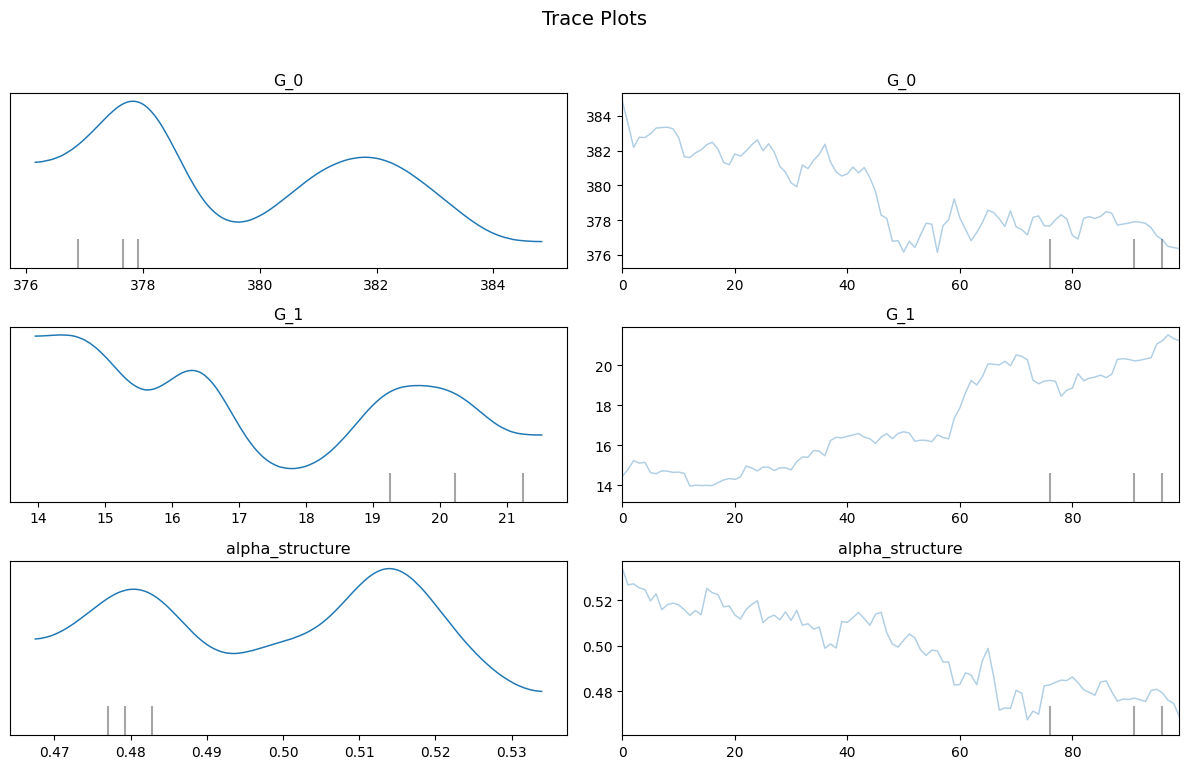

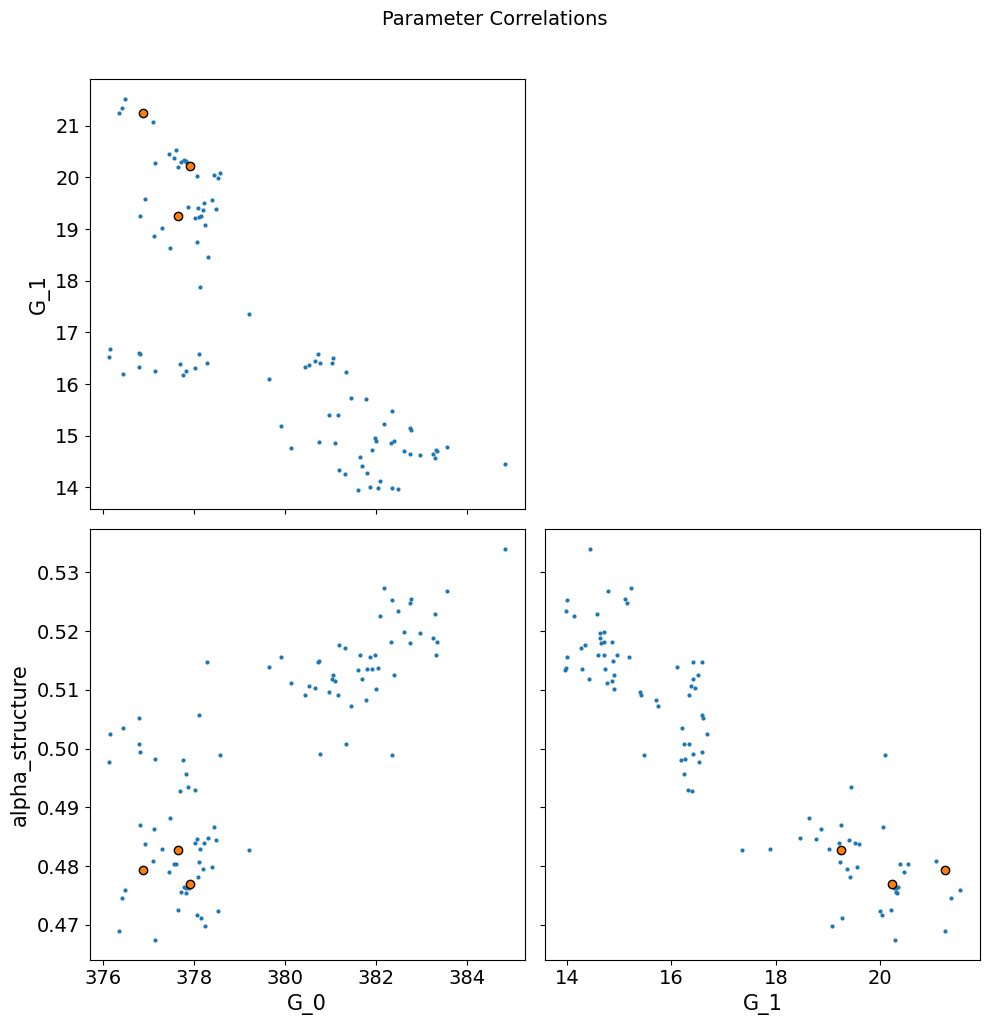

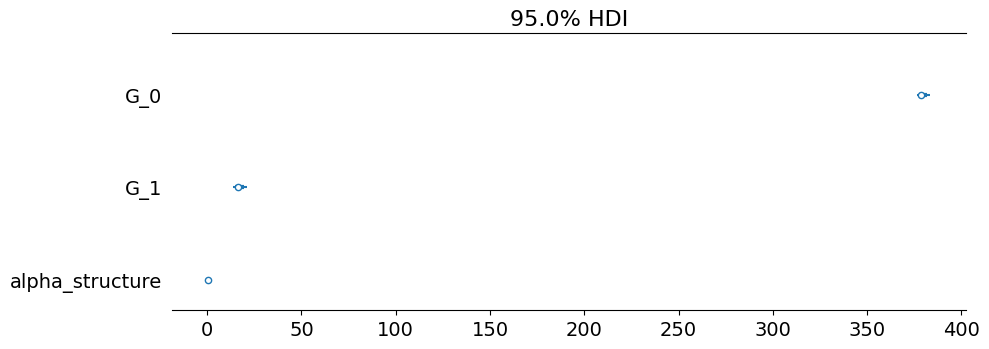

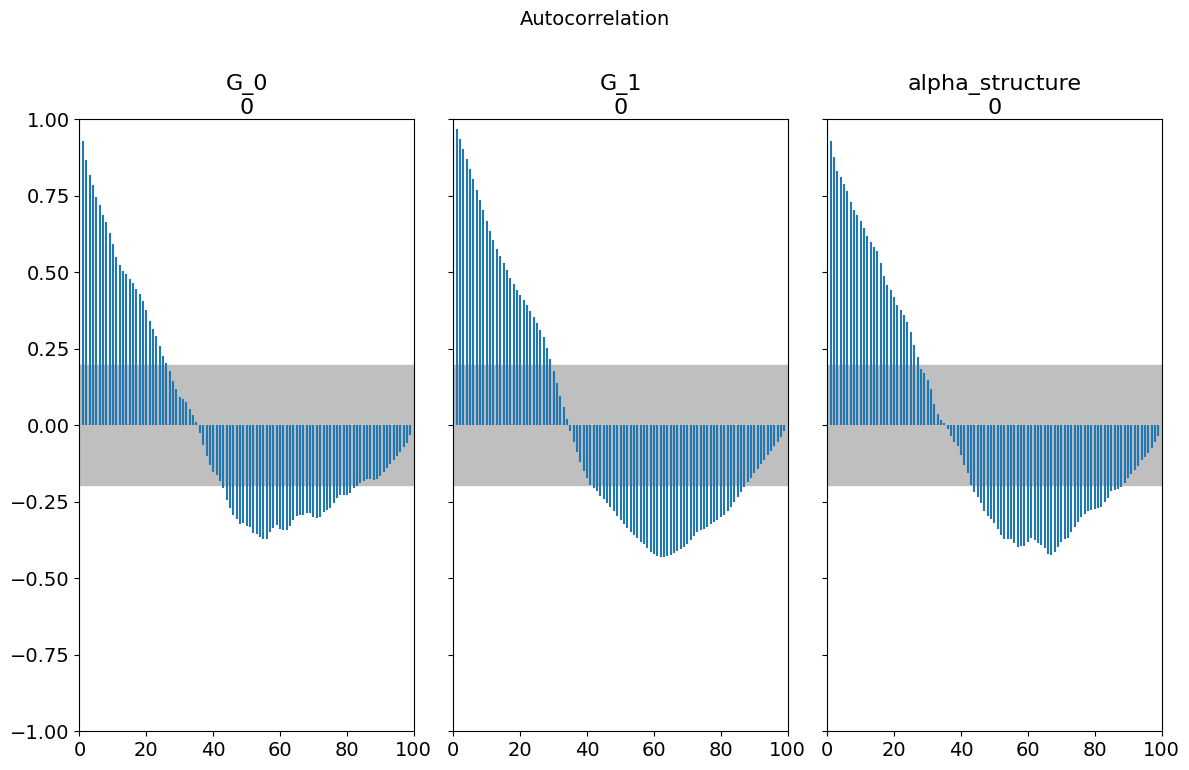

In [7]:
key_params = ["G_0", "G_1", "alpha_structure"]
print_convergence_summary(result, key_params)

print("\n### Diagnostic Targets")
print("| Metric | Target | Interpretation |")
print("|--------|--------|----------------|")
print("| **R-hat** | < 1.01 | Convergence |")
print("| **ESS** | > 400 | Sample count |")
print("| **Divergences** | < 1% | Quality |")

display_arviz_diagnostics(result, key_params, fast_mode=FAST_MODE)

### Convergence Diagnostics

**Diagnostic Targets:**

| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Convergence |
| **ESS** | > 400 | Sample count |
| **Divergences** | < 1% | Quality |

## 6. Save Results

In [8]:
save_fikh_results(model_fit, result, "fmlikh", "saos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fmlikh/saos/
  nlsq_params_saos.json: 20 parameters
  posterior_saos.json: 100 draws


## Key Takeaways

1. **FMLIKH SAOS captures broad frequency spectra** (vs single-mode limits)
2. **Multiple crossover frequencies** $\omega_c,i \sim 1/\tau_i$ from mode distribution
3. **Composite Cole-Cole** superposition of depressed arcs
4. **Extended power-law regimes** over wider $\omega$ range
5. **Mode decomposition** shows structural level contributions vs frequency
6. **Residual analysis** of moduli validates multi-mode relaxation spectrum

---

## Further Reading

- **[FMLIKH SAOS Analysis](../../docs/source/models/fikh/fmlikh.rst#stretched-exponential-vs-fractional-modes)**: Frequency-domain mode superposition
- **[Cole-Cole Decomposition](../../docs/source/models/fikh/fmlikh.rst#shared-vs-per-mode-fractional-order)**: Identifying mode features in complex plane

### Key References

1. Jaishankar, A. & McKinley, G.H. (2014). "A fractional K-BKZ constitutive formulation." *J. Rheol.*, 58, 1751-1788.
2. Wei, Y. et al. (2018). "A multimode structural kinetics constitutive equation." *J. Rheol.*, 62(1), 321-342.

### Next Steps

**Next**: NB12 (LAOS) — multi-mode harmonics and nonlinear oscillatory response